# Time-explicit LCA of an electric vehicle


This notebook shows how to use `bw_timex` with a cradle-to-grave case study of an electric vehicle. The case study is simplified, not meant to reflect the complexity of electric mobility but to demonstrate hot to use `bw_timex`. 

More information on the inner workings of `bw_timex` can be found [here](https://timex.readthedocs.io/en/latest/content/theory.html).


> **Note:** This is the "premise" version of this notebook that works with ecoinvent and premise data. If you don't have access to that, please check out the ["standalone" version](https://github.com/brightway-lca/bw_timex/blob/main/notebooks/example_electric_vehicle_standalone.ipynb) of this notebook.

In [1]:
import bw2data as bd

bd.projects.set_current("timex")

## Prospective background databases

The `bw_timex` package itself does not provide any data - specifying prospective and dynamic information is up to the user. In this example, we use data from [ecoinvent v3.10](https://ecoinvent.org/), and create a set of prospective databases with [`premise`](https://github.com/polca/premise). We applied projections for the future electricity sectors using the SSP2-RCP19 pathway from the IAM IMAGE. We selected this pathway to simply demonstrate some future development in this case study, and many other models and pathways are available. 
In the [premise documentation](https://premise.readthedocs.io/en/latest/) you can find instructions for the creation of prospective background databases. 


In [2]:
db_2020 = bd.Database("ei310_IMAGE_SSP2_RCP19_2020_electricity")
db_2030 = bd.Database("ei310_IMAGE_SSP2_RCP19_2030_electricity")
db_2040 = bd.Database("ei310_IMAGE_SSP2_RCP19_2040_electricity")

## Case study setup


In this study, we consider the following production system for our ev. Purple boxes are foreground, cyan boxes are background (i.e., ecoinvent/premise).

```{mermaid}
flowchart LR
    glider_production(glider production):::ei-->ev_production
    powertrain_production(powertrain production):::ei-->ev_production
    battery_production(battery production):::ei-->ev_production
    ev_production(ev production):::fg-->driving
    electricity_generation(electricity generation):::ei-->driving
    driving(driving):::fg-->used_ev
    used_ev(used ev):::fg-->glider_eol(glider eol):::ei
    used_ev-->powertrain_eol(powertrain eol):::ei
    used_ev-->battery_eol(battery eol):::ei

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```

### Modeling the production system

Now, we need to build this with brightway. If you are not interested in the modeling details, feel free to skip this section.

For our ev model we make the following assumptions:

In [3]:
ELECTRICITY_CONSUMPTION = 0.2 # kWh/km
MILEAGE = 150_000 # km
LIFETIME = 15 # years

# Overall mass: 1200 kg
MASS_GLIDER = 840 # kg
MASS_POWERTRAIN = 80 # kg
MASS_BATTERY = 280 # kg

First, we create a new foreground database:

In [4]:
if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.register()

Now, let's creating the foreground activities:


In [5]:
ev_production = foreground.new_node("ev_production", name="production of an electric vehicle", unit="unit")
ev_production['reference product'] = "electric vehicle"
ev_production.save()

driving = foreground.new_node("driving", name="driving an electric vehicle", unit="transport over an ev lifetime")
driving['reference product'] = "transport"
driving.save()

used_ev = foreground.new_node("used_ev", name="used electric vehicle", unit="unit")
used_ev['reference product'] = "used electric vehicle"
used_ev.save()

We take the actual process data from ecoinvent. However, the ecoinvent processes for the ev part production contain exchanges for the end of life treatment in the production processes already, which we want to separate. So let's fix that first by creating new activities without the eol processes:

In [6]:
for db in [db_2020, db_2030, db_2040]:
    for code in ["glider_production_without_eol", "powertrain_production_without_eol", "battery_production_without_eol"]:
        try:
            act = db.get(code=code)
            act.delete()
        except:
            pass
    
    glider_production = db.get(name="glider production, passenger car")
    glider_production_without_eol = glider_production.copy(code="glider_production_without_eol", database=db.name)
    glider_production_without_eol["name"] = "glider production, passenger car, without EOL"
    # glider_production_without_eol["reference product"] = "glider"
    glider_production_without_eol.save()
    for exc in glider_production_without_eol.exchanges():
        if exc.input["name"] == "market for used glider, passenger car":
            exc.delete()
    
    powertrain_production = db.get(name="powertrain production, for electric passenger car")
    powertrain_production_without_eol = powertrain_production.copy(code="powertrain_production_without_eol", database=db.name)
    powertrain_production_without_eol["name"] = "powertrain production, for electric passenger car, without EOL"
    # powertrain_production_without_eol["reference product"] = "powertrain"
    powertrain_production_without_eol.save()
    for exc in powertrain_production_without_eol.exchanges():
        if exc.input["name"] == "market for used powertrain from electric passenger car, manual dismantling":
            exc.delete()
    
    battery_production = db.get(name="battery production, Li-ion, LiMn2O4, rechargeable, prismatic")
    battery_production_without_eol = battery_production.copy(code="battery_production_without_eol", database=db.name)
    battery_production_without_eol["name"] = "battery production, Li-ion, LiMn2O4, rechargeable, prismatic, without EOL"
    # battery_production_without_eol["reference product"] = "battery"
    battery_production_without_eol.save()
    # For the battery, some waste treatment is buried in the process "battery cell production, Li-ion, 
    # LiMn2O4" - but not for the whole mass of the battery(?). For simplicity, we just leave it in there.

Now, let's build the exchanges, starting with the ev production:

In [7]:
glider_production = db_2020.get(code="glider_production_without_eol")
powertrain_production = db_2020.get(code="powertrain_production_without_eol")
battery_production = db_2020.get(code="battery_production_without_eol")

ev_production.new_edge(input=ev_production, amount=1, type="production").save()

glider_to_ev = ev_production.new_edge(
    input=glider_production,
    amount=MASS_GLIDER, 
    type="technosphere"
)
powertrain_to_ev = ev_production.new_edge(
    input=powertrain_production, 
    amount=MASS_POWERTRAIN, 
    type="technosphere"
)
battery_to_ev = ev_production.new_edge(
    input=battery_production, 
    amount=MASS_BATTERY, 
    type="technosphere"
)

... the end of life:

In [8]:
glider_eol = db_2020.get(name="treatment of used glider, passenger car, shredding")
powertrain_eol = db_2020.get(name="treatment of used powertrain for electric passenger car, manual dismantling")
battery_eol = db_2020.get(name="market for used Li-ion battery")

used_ev.new_edge(input=used_ev, amount=-1, type="production").save()  # -1 as this gets rid of a used car

used_ev_to_glider_eol = used_ev.new_edge(
    input=glider_eol,
    amount=-MASS_GLIDER,
    type="technosphere",
)
used_ev_to_powertrain_eol = used_ev.new_edge(
    input=powertrain_eol,
    amount=-MASS_POWERTRAIN,
    type="technosphere",
)
used_ev_to_battery_eol = used_ev.new_edge(
    input=battery_eol,
    amount=-MASS_BATTERY,
    type="technosphere",
)

...and, finally, driving:

In [9]:
electricity_production = db_2020.get(name="market group for electricity, low voltage", location="WEU")

driving.new_edge(input=driving, amount=1, type="production").save()

driving_to_used_ev = driving.new_edge(input=used_ev, amount=-1, type="technosphere")
ev_to_driving = driving.new_edge(
    input=ev_production, 
    amount=1, 
    type="technosphere"
)
electricity_to_driving = driving.new_edge(
    input=electricity_production,
    amount=ELECTRICITY_CONSUMPTION * MILEAGE,
    type="technosphere",
)

### Adding temporal information

Now that the production system is modelled, we can add temporal distributions at the exchange level. The temporal information we want to embed in our product system looks somewhat like this:

```{mermaid}
flowchart LR
    glider_production(glider production):::ei-->|"0-2 years prior \n &nbsp;"|ev_production
    powertrain_production(powertrain production):::ei-->|"1 year prior \n &nbsp;"|ev_production
    battery_production(battery production):::ei-->|"&nbsp; \n 1 year prior"|ev_production
    ev_production(ev production):::fg-->|"0-3 months prior \n &nbsp;"|driving
    electricity_generation(electricity generation):::ei-->|uniformly distributed \n over lifetime|driving
    driving(driving):::fg-->|"after ev lifetime \n &nbsp;"|used_ev
    used_ev(used ev):::fg-->|3 months after \n ev lifetime|glider_eol(glider eol):::ei
    used_ev-->|3 months after \n ev lifetime|powertrain_eol(powertrain eol):::ei
    used_ev-->|3 months after \n ev lifetime|battery_eol(battery eol):::ei

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```

To include this temopral information, we use the `TemporalDistribution` class from `bw_temporalis`. For more info, take a look at the [bw_temporalis documentation](https://github.com/brightway-lca/bw_temporalis).

Notably, in addition to the timestamp of the occurence of the process (which is shown in the flowchart above), we also need to specify the amount share of the exchange that happens at that time to fully define a `TemporalDistribution`.


In [10]:
from bw_temporalis import TemporalDistribution, easy_timedelta_distribution
import numpy as np

td_assembly_and_delivery = TemporalDistribution(
    date=np.array([-3, -2], dtype="timedelta64[M]"), amount=np.array([0.2, 0.8])
)

td_glider_production = TemporalDistribution(
    date=np.array([-2, -1, 0], dtype="timedelta64[Y]"), amount=np.array([0.7, 0.1, 0.2])
)

td_produce_powertrain_and_battery = TemporalDistribution(
    date=np.array([-1], dtype="timedelta64[Y]"), amount=np.array([1])
)

td_use_phase = easy_timedelta_distribution(
    start=0,
    end=LIFETIME,
    resolution="Y",
    steps=(LIFETIME + 1),
    kind="uniform", # you can also do "normal" or "triangular" distributions
)

td_disassemble_used_ev = TemporalDistribution(
    date=np.array([LIFETIME + 1], dtype="timedelta64[Y]"), amount=np.array([1])
)

td_treating_waste = TemporalDistribution(
    date=np.array([3], dtype="timedelta64[M]"), amount=np.array([1])
)

Let's explore what a `TemporalDistribution` looks like:

<AxesSubplot:xlabel='Time (Months)', ylabel='Amount'>

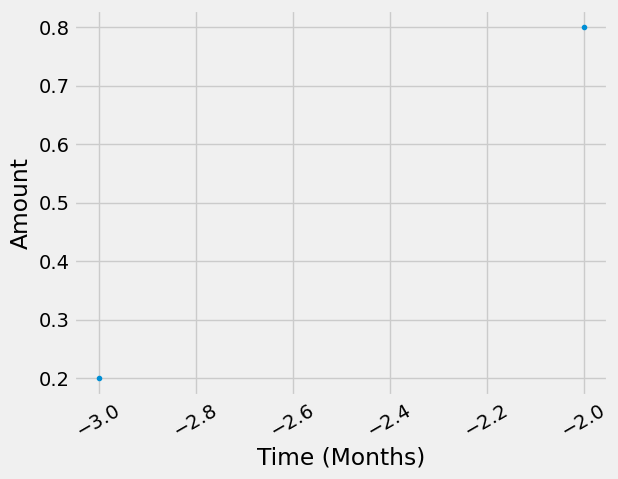

In [11]:
td_assembly_and_delivery.graph(resolution="M")

<AxesSubplot:xlabel='Time (Months)', ylabel='Amount'>

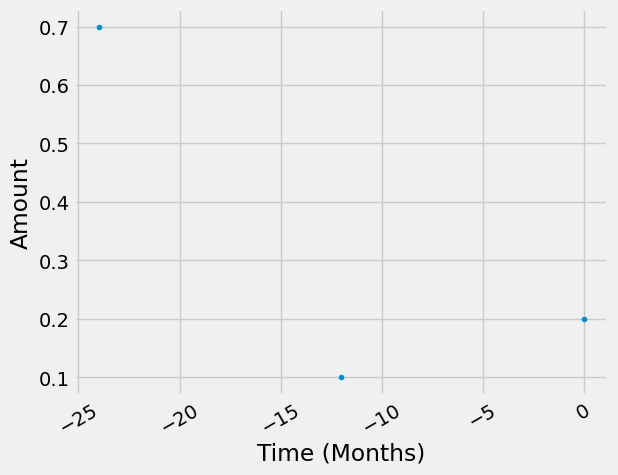

In [12]:
td_glider_production.graph(resolution="M")

Starting from the functional unit in our supply chain graph, the temporal distributions of consecutive edges get "multiplied", or more specifically, convolved. Let's look at an example to clarify this. The assembly and delivery of our ev happens either 2 or 3 months before we can start using it. Each of these occurences of this process demands a glider, which also has a temporal distribution that then gets convolved "back in time". Also pay attention to how the amounts get scaled.

<AxesSubplot:xlabel='Time (Months)', ylabel='Amount'>

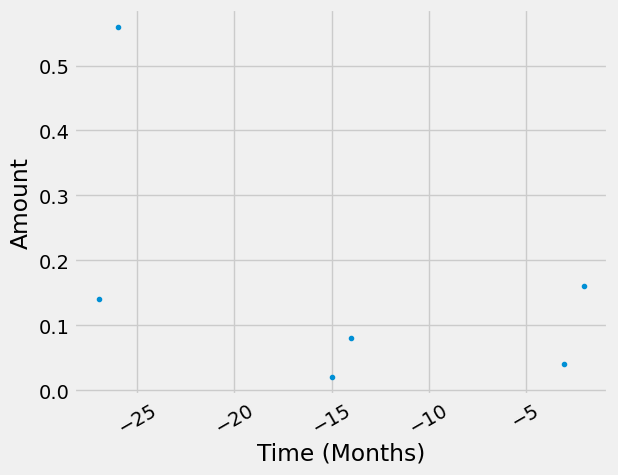

In [13]:
(td_assembly_and_delivery * td_glider_production).graph(resolution="M")

We now add the temporal information to the exchanges of our EV. We add temporal distributions to all (technosphere) exchanges, but you don't have to.


In [31]:
glider_to_ev["temporal_distribution"] = td_glider_production
glider_to_ev.save()

powertrain_to_ev["temporal_distribution"] = td_produce_powertrain_and_battery
powertrain_to_ev.save()

battery_to_ev["temporal_distribution"] = td_produce_powertrain_and_battery
battery_to_ev.save()

ev_to_driving["temporal_distribution"] = td_assembly_and_delivery
ev_to_driving.save()

electricity_to_driving["temporal_distribution"] = td_use_phase
electricity_to_driving.save()

driving_to_used_ev["temporal_distribution"] = td_disassemble_used_ev
driving_to_used_ev.save()

used_ev_to_glider_eol["temporal_distribution"] = td_treating_waste
used_ev_to_glider_eol.save()

used_ev_to_powertrain_eol["temporal_distribution"] = td_treating_waste
used_ev_to_powertrain_eol.save()

used_ev_to_battery_eol["temporal_distribution"] = td_treating_waste
used_ev_to_battery_eol.save()

## LCA using `bw_timex`


As usual, we need to select an impact assessment method:

In [32]:
method = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')

`bw_timex` also needs to know the representative time of the databases:

In [33]:
from datetime import datetime

database_dates = {
    db_2020.name: datetime.strptime("2020", "%Y"),
    db_2030.name: datetime.strptime("2030", "%Y"),
    db_2040.name: datetime.strptime("2040", "%Y"),
    "foreground": "dynamic", # flag databases that should be temporally distributed with "dynamic"
}

Now, we can instantiate a `TimexLCA`. It's structure is similar to a normal `bw2calc.LCA`, but with the additional argument `database_dates`.

Not sure about the required inputs? Check the documentation using `?`. All our classes and methods have docstrings!

In [34]:
from bw_timex import TimexLCA
TimexLCA?

Init signature: TimexLCA(demand: dict, method: tuple, database_dates: dict = None) -> None
Docstring:     
Class to perform time-explicit LCA calculations.

A TimexLCA retrieves the LCI of processes occuring at explicit points in time and relinks their technosphere
exchanges to match the technology landscape at that point in time, while keeping track of the timing of the
resulting emissions. As such, it combines prospective and dynamic LCA approaches.

TimexLCA first calculates a static LCA, which informs a priority-first graph traversal. From the graph traversal,
temporal relationships between exchanges and processes are derived. Based on the timing of the processes, bw_timex
matches the processes at the intersection between foreground and background to the best available background
databases. This temporal relinking is achieved by using datapackages to add new time-specific processes. The new
processes and their exchanges to other technosphere processes or biosphere flows extent the 

Let's instantiate a `TimexLCA` object for our "driving" activity:

In [35]:
tlca = TimexLCA({driving: 1}, method, database_dates)

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Next, we build a timeline of the exchanges. To do this, we can call the `build_timeline()` method, which does the graph traversal and creates a timeline dataframe from the results. The exchanges (rows of the dataframe) are aggregated to the resolution specified in the argument `temporal_grouping`. There are also many more options to specify the timeline creation and graph traversal process. Here are the most important ones:
- `temporal_grouping`: temporal resolution to which processes will be aggregated,"year" (default), "month", "day" or "hour"
- `interpolation_type`: How the best fitting background database is selected: "linear"(default), "closest"
- `edge_filter_function`: Custom filter function specifying when to stop the graph traversal.
- `cutoff`: stops graph traversal for nodes below this contribution to the static impact score.
- `max_calc`: stops graph traversal if this number of nodes has been traversed

For all these options, we provide sensible default values. Of course you can always just check the docstrings to see all your options and our assumptions for default values. 

So, let's build the timeline. We choose a monthly temporal grouping here because we use that resolution in our temporal distributions.


In [36]:
tlca.build_timeline(temporal_grouping="month")

/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timex_lca.py:194: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 9


/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:527: Warning: Reference date 2040-08-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(
/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timeline_builder.py:527: Warning: Reference date 2040-11-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(


date_producer                                      producer_name  \
0     2022-05-01      glider production, passenger car, without EOL   
1     2022-06-01      glider production, passenger car, without EOL   
2     2023-05-01      glider production, passenger car, without EOL   
3     2023-05-01  powertrain production, for electric passenger ...   
4     2023-05-01  battery production, Li-ion, LiMn2O4, rechargea...   
5     2023-06-01      glider production, passenger car, without EOL   
6     2023-06-01  powertrain production, for electric passenger ...   
7     2023-06-01  battery production, Li-ion, LiMn2O4, rechargea...   
8     2024-05-01      glider production, passenger car, without EOL   
9     2024-05-01                  production of an electric vehicle   
10    2024-06-01      glider production, passenger car, without EOL   
11    2024-06-01                  production of an electric vehicle   
12    2024-08-01          market group for electricity, low voltage   
13    2024-08-01                        driving an electric vehicle   
14    2025-08-01          market group for electricity, low voltage   
15    2026-08-01          market group for electricity, low voltage   
16    2027-08-01          market group for electricity, low voltage   
17    2028-08-01          market group for electricity, low voltage   
18    2029-08-01          market group for electricity, low voltage   
19    2030-08-01          market group for electricity, low voltage   
20    2031-08-01          market group for electricity, low voltage   
21    2032-08-01          market group for electricity, low voltage   
22    2033-08-01          market group for electricity, low voltage   
23    2034-08-01          market group for electricity, low voltage   
24    2035-08-01          market group for electricity, low voltage   
25    2036-08-01          market group for electricity, low voltage   
26    2037-08-01          market group for electricity, low voltage   
27    2038-08-01          market group for electricity, low voltage   
28    2039-08-01          market group for electricity, low voltage   
29    2040-08-01                              used electric vehicle   
30    2040-11-01                     market for used Li-ion battery   
31    2040-11-01  treatment of used powertrain for electric pass...   
32    2040-11-01  treatment of used glider, passenger car, shred...   

   date_consumer                      consumer_name  amount  \
0     2024-05-01  production of an electric vehicle   588.0   
1     2024-06-01  production of an electric vehicle   588.0   
2     2024-05-01  production of an electric vehicle    84.0   
3     2024-05-01  production of an electric vehicle    80.0   
4     2024-05-01  production of an electric vehicle   280.0   
5     2024-06-01  production of an electric vehicle    84.0   
6     2024-06-01  production of an electric vehicle    80.0   
7     2024-06-01  production of an electric vehicle   280.0   
8     2024-05-01  production of an electric vehicle   168.0   
9     2024-08-01        driving an electric vehicle     0.2   
10    2024-06-01  production of an electric vehicle   168.0   
11    2024-08-01        driving an electric vehicle     0.8   
12    2024-08-01        driving an electric vehicle  1875.0   
13    2024-08-01                                 -1     1.0   
14    2024-08-01        driving an electric vehicle  1875.0   
15    2024-08-01        driving an electric vehicle  1875.0   
16    2024-08-01        driving an electric vehicle  1875.0   
17    2024-08-01        driving an electric vehicle  1875.0   
18    2024-08-01        driving an electric vehicle  1875.0   
19    2024-08-01        driving an electric vehicle  1875.0   
20    2024-08-01        driving an electric vehicle  1875.0   
21    2024-08-01        driving an electric vehicle  1875.0   
22    2024-08-01        driving an electric vehicle  1875.0   
23    2024-08-01        driving an electric vehicle  1875.0   
24    2024-08

The temporal market shares in the timeline (right most column above) specify the share of the amount of an exchange to be sourced from the respective database. 
`None` means that the exchange is in the foreground supply chain, and not at the intersection with the background system.  

Next, we calculate the time-explicit LCI. The `TimexLCA.lci()` function takes care of all the relinking, based on the information from the timeline. 

In [37]:
tlca.lci()

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 5.78e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 5.78e+12)
  warnings.warn(msg, UmfpackWarning)


Taking a look at the `dynamic_inventory` that was now created, we can see that it has more rows (emissions) than our usual biosphere3 flows. Instead of one row for each emission in the biosphere database we now get one row for each emission at each point in time.

In [40]:
tlca.dynamic_inventory

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 65859 stored elements and shape (61709, 80718)>

The standard, non-dynamic inventory has far less rows because the temporal resolution is missing. Looking at the timeline again, we see that we have processes at 23 different points in time (only counting the ones that actually directly procude emissions), which exactly matches the ratio of the dimensions of our two inventories:

In [41]:
tlca.inventory.shape # (#rows, #cols)

(2683, 80718)

In [42]:
tlca.dynamic_inventory.shape[0]/tlca.inventory.shape[0]

23.0

While under the hood, the dynamic inventory is calculated as a sparse matrix, there is also a more human-friendly version as a pandas DataFrame:

In [43]:
tlca.dynamic_inventory_df

date        amount  flow  activity
876   2022-05-01  3.281494e+04  1584    108727
824   2022-05-01  8.636928e+03  1472    108727
1576  2022-05-01  4.231631e+03  3193    108727
578   2022-05-01  4.201366e+03   842    108727
875   2022-05-01  9.198843e+02  1583    108727
...          ...           ...   ...       ...
62048 2040-11-01 -4.535713e-08  1819    108757
62282 2040-11-01 -1.478520e-07  1922    108757
64549 2040-11-01 -3.534886e-02  3721    108758
61017 2040-11-01 -4.156468e-01  1030    108759
61019 2040-11-01 -3.893688e+00  1030    108757

[65859 rows x 4 columns]

If we are only interested in the new overall time-explicit scores and don't care about the timing of the emissions, we can set `build_dynamic_biosphere=False` (default is `True`), which saves time and memory. In that case, you only get the `TimexLCA.inventory`, but not the `TimexLCA.dynamic_inventory`.

In case the timing of emissions is not important, one can directly calculate the LCIA the "standard way" using static characterization factors. Per default, the following calculates the static lcia score based on the impact method chosen in the very beginning:

In [44]:
tlca.static_lcia()
tlca.static_score   #kg CO2-eq

11821.850158724601

At this point, we can already compare these time-explicit results to the results of an "ordinary", completely static LCA. These already exist within the TimexLCA class, originally to set the priorities for the graph traversal:

In [45]:
tlca.base_lca.score

20858.470012031627

## Dynamic Characterization
In addition to the standard static characterization, the time-explicit, dynamic inventory generated by a `TimexLCA` allows for dynamic characterization. Users can provide their own dynamic characterization functions and link them to corresponding biosphere flows (see example on [dynamic characterization](https://github.com/TimoDiepers/timex/blob/main/notebooks/example_simple_dynamic_characterization.ipynb)). 

Alternatively, you can use the functions from our separate (but fully compatible) package [dynamic_characterization](https://dynamic-characterization.readthedocs.io/en/latest/). We provide two different metrics for dynamic LCIA of Climate Change: Radiative forcing [W/m2] and Global Warming Potential (GWP) [kg CO2-eq]. For both of these metrics, we have parameterized dynamic characterization functions for all GHG's that [IPCC AR6](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-7/) provides data for.

For the dynamic characterization, users can also choose the length of the considered time horizon (`time_horizon`) and whether it is a fixed time horizon (`fixed_time_horizon`). Fixed means that the time horizon for all emissions (no matter when they occur) starts counting at the time of the functional unit, resulting in shorter time horizons for emissions occuring later. If the time horizon is not fixed (this is what conventional impact assessment factors assume), it starts counting from the timing of the emission.


### Radiative forcing


Let's characterize our dynamic inventory, regarding radiative forcing with a fixed time horizon and the default time horizon length of 100 years:

In [186]:
tlca.dynamic_lcia(metric="radiative_forcing", fixed_time_horizon=True)

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:80: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions from `dynamic_characterization` meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category. You can look up the mapping in the bw_timex.dynamic_characterizer.characterization_functions.
  warnings.warn(


date        amount  flow  activity
0      2023-05-01 05:49:12  5.049646e-13  1031    108703
1      2023-05-01 05:49:12  2.470251e-18  3792    108703
2      2023-05-01 05:49:12  6.890517e-19  4217    108703
3      2023-05-01 05:49:12  3.461317e-18  1366    108703
4      2023-05-01 05:49:12  1.463020e-18  1374    108703
...                    ...           ...   ...       ...
146565 2123-11-02 03:03:36  2.669520e-16  1034    108734
146566 2123-11-02 03:03:36  1.487574e-21  1369    108733
146567 2123-11-02 03:03:36  2.640643e-21   226    108733
146568 2123-11-02 03:03:36  7.511111e-17  1390    108733
146569 2123-11-02 03:03:36  3.126878e-48  1152    108734

[146570 rows x 4 columns]

The method call returns a dataframe of all the individual emissions at their respective timesteps (tlca.characterized_inventory), but we can also just look at the overall score:

In [189]:
tlca.dynamic_score #W/m2 (radiative forcing)

1.0214828094580987e-09

To visualize the results, we provide a simple plotting functions:

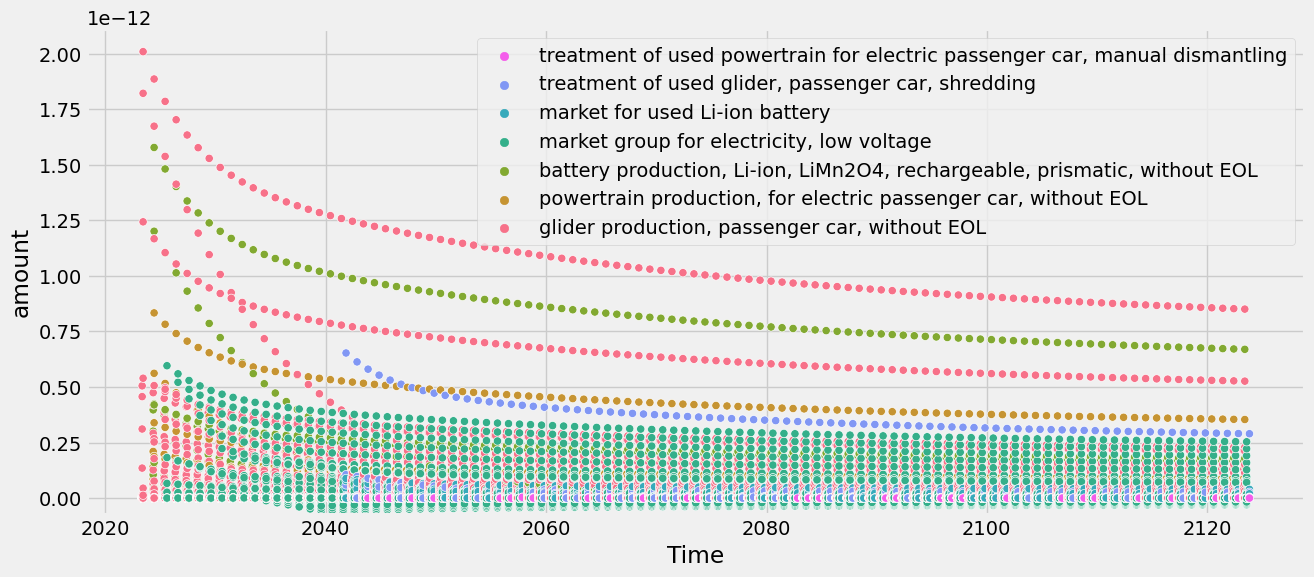

In [200]:
tlca.plot_dynamic_characterized_inventory()  

This can be a bit messy, though, because all the individual impacts caused by individual emissions (e.g., CO2, CH4, N2O, ...) appear. Luckily, there is also an option to sum the emissions within each activity:

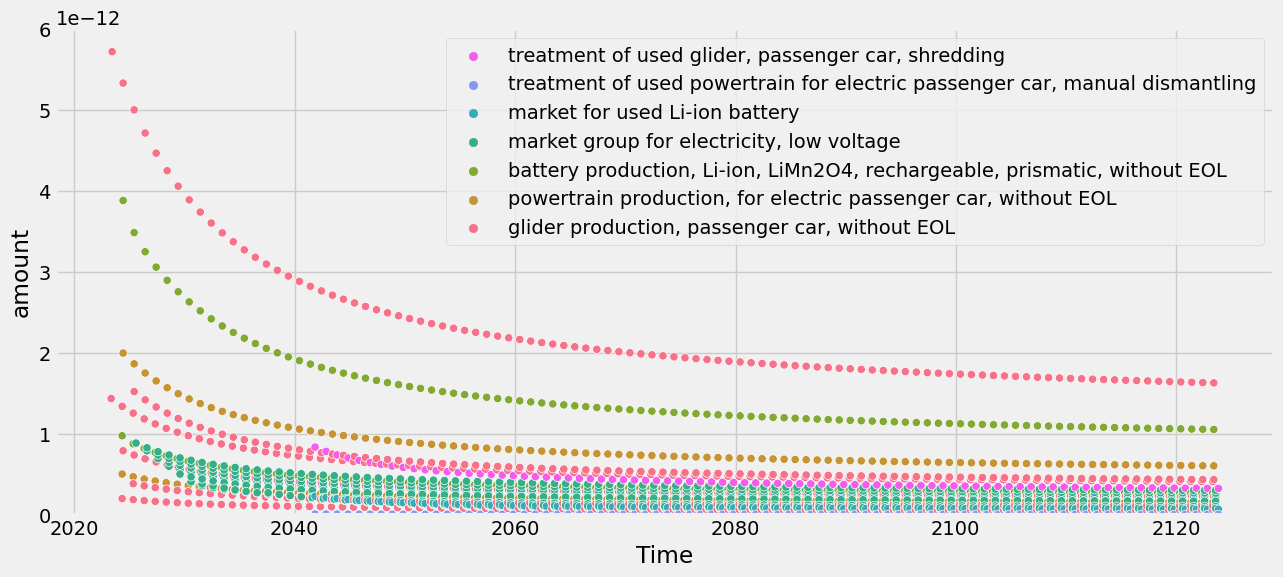

In [201]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

There is also a flag to plot the cumulative score over time:

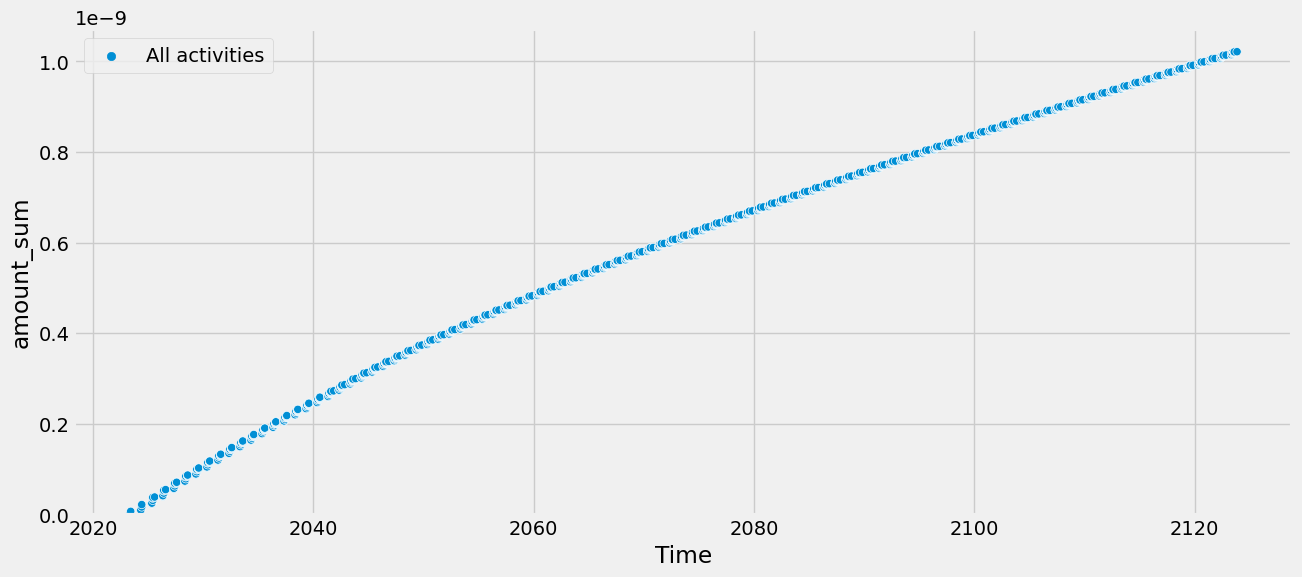

In [202]:
tlca.plot_dynamic_characterized_inventory(sum_activities=True, cumsum=True)

### GWP


Similar options are available for the metric GWP, which compares the radiative forcing of a GHG to that of CO2 over a certain time horizon (commonly 100 years, but it can be set flexibly in `time_horizon`).

In [203]:
tlca.dynamic_lcia(metric="GWP", fixed_time_horizon=False, time_horizon = 70)
tlca.dynamic_score #kg CO2-eq (GWP)

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:80: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions from `dynamic_characterization` meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category. You can look up the mapping in the bw_timex.dynamic_characterizer.characterization_functions.
  warnings.warn(
/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:262: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


11996.445963730823

Plotting the GWP results over time:

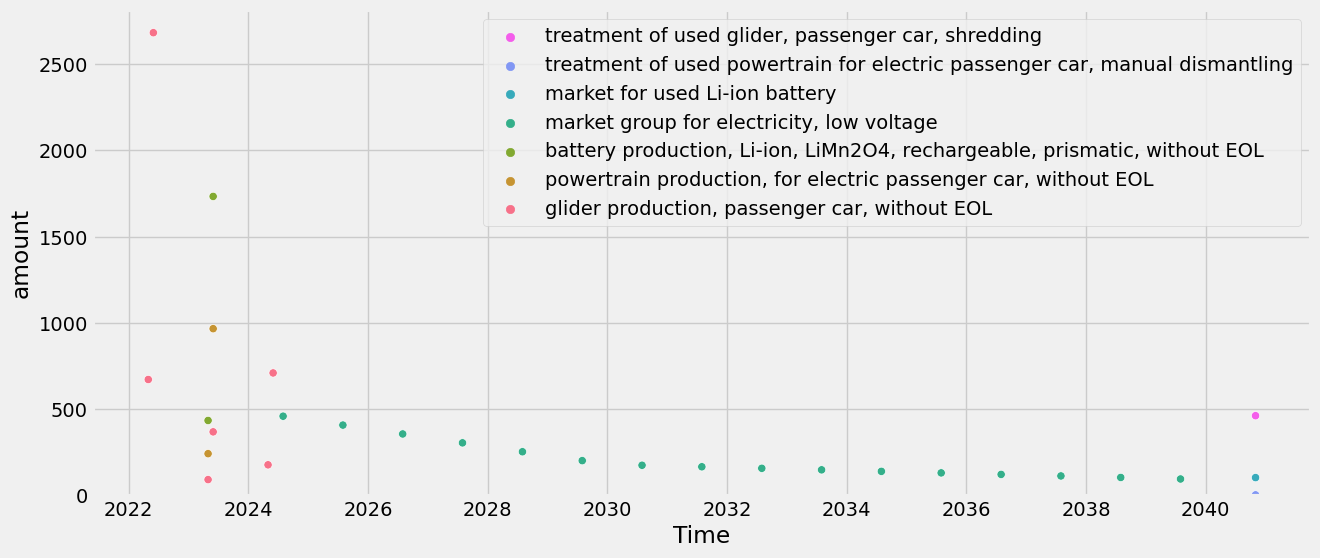

In [206]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

Cumulative:

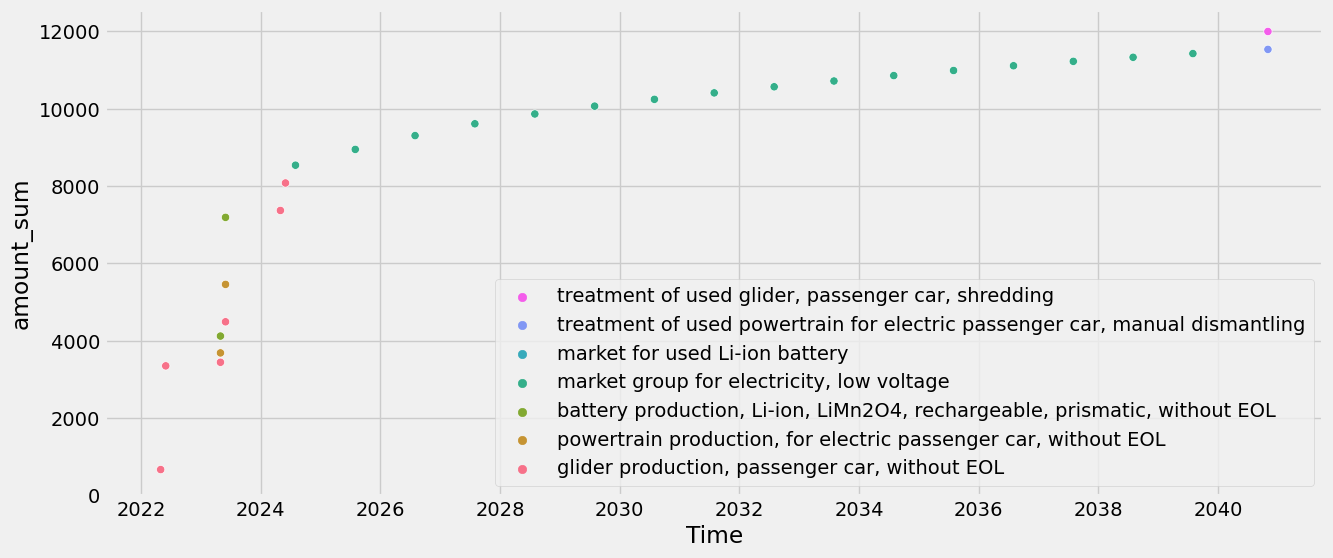

In [207]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True, cumsum=True)

### Comparison of time-explicit results to static results
It's helpful to understand how the time-explicit results differ from those using static assessments. 

We compare the time-explicit results with those of an LCA for the year 2020 and 2040 for the standard GWP100 metric (time horizon=100 and no fixed time horizon). This means we neglect the additional differences of the time-explicit results that would arise from using dynamic LCIA. 

Time-explicit scores:

In [208]:
tlca.dynamic_lcia(metric="GWP", fixed_time_horizon=False, time_horizon=100)
tlca.dynamic_score

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:80: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions from `dynamic_characterization` meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category. You can look up the mapping in the bw_timex.dynamic_characterizer.characterization_functions.
  warnings.warn(
/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:262: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


11653.498778351013

The 2020 (static) score has already been calculated by TimexLCA in the beginning, but we can still access the score:

In [209]:
tlca.base_lca.score

20858.470012031627

However, further down we also want to look at what part of the life cycle has what contribution. To get this info, we need some more calculations:

In [210]:
static_scores = {}
for exc in driving.technosphere():
    if exc.input == ev_production:
        for subexc in exc.input.technosphere():
            tlca.base_lca.lcia(demand={subexc.input.id: exc.amount * subexc.amount * subexc.input.rp_exchange().amount})
            static_scores[subexc.input["name"]] = tlca.base_lca.score
    elif exc.input == used_ev:
        for subexc in exc.input.technosphere():
            tlca.base_lca.lcia(demand={subexc.input.id: exc.amount * subexc.amount * subexc.input.rp_exchange().amount})
            static_scores[subexc.input["name"]] = tlca.base_lca.score
    else:
        tlca.base_lca.lcia(demand={exc.input.id: exc.amount})
        static_scores[exc.input["name"]] = tlca.base_lca.score

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Similarly, we calculate the 2040 (prospective) scores by just changing the database the exchanges point to:

In [211]:
import bw2calc as bc

# first create a copy of the system and relink to processes from 2040 database
try:
    prospective_driving = driving.copy(code="prospective_driving", name="driving an electric vehi0cle in 2040")
except:
    foreground.get(code="prospective_driving").delete()
    prospective_driving = driving.copy(code="prospective_driving", name="driving an electric vehicle in 2040")
    

for exc in prospective_driving.technosphere():
    if exc.input == ev_production:
        prospective_ev_production = ev_production.copy(name="production of an electric vehicle in 2040")
        exc.input = prospective_ev_production
        exc.save()
        for subexc in prospective_ev_production.technosphere():
            subexc.input = bd.get_node(
                database=db_2040.name,
                name=subexc.input["name"],
                product=subexc.input["reference product"],
                location=subexc.input["location"],
            )
            subexc.save()
    elif exc.input == used_ev:
        prospective_used_ev = used_ev.copy(name="used electric vehicle in 2040")
        exc.input = prospective_used_ev
        exc.save()
        for subexc in prospective_used_ev.technosphere():
            subexc.input = bd.get_node(
                database=db_2040.name,
                name=subexc.input["name"],
                product=subexc.input["reference product"],
                location=subexc.input["location"],
            )
            subexc.save()
    else:
        exc.input = bd.get_node(
            database=db_2040.name,
            name=exc.input["name"],
            product=exc.input["reference product"],
            location=exc.input["location"],
        )
    exc.save()

prospective_scores = {}
lca = bc.LCA({prospective_driving.key: 1}, method)
lca.lci(factorize=True)
for exc in prospective_driving.technosphere():
    if exc.input["name"] in (prospective_ev_production["name"], prospective_used_ev["name"]):
        for subexc in exc.input.technosphere():
            lca.lcia(demand={subexc.input.id: exc.amount * subexc.amount * subexc.input.rp_exchange().amount})
            prospective_scores[subexc.input["name"]] = lca.score
    else:
        lca.lcia(demand={exc.input.id: exc.amount})
        prospective_scores[exc.input["name"]] = lca.score

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 2.48e+12)
  warnings.warn(msg, UmfpackWarning)


Lets compare the overall scores:

In [212]:
print("Static score: ", sum(static_scores.values())) # should be the same as tlca.base_lca.score
print("Prospective score: ", sum(prospective_scores.values()))
print("Time-explicit score: ", tlca.dynamic_score)

Static score:  20858.470012031674
Prospective score:  6522.389036408176
Time-explicit score:  11653.498778351013


To better understand what's going on, let's plot the scores as a waterfall chart  based on timing of emission. Also, we can look at the "first-level contributions":

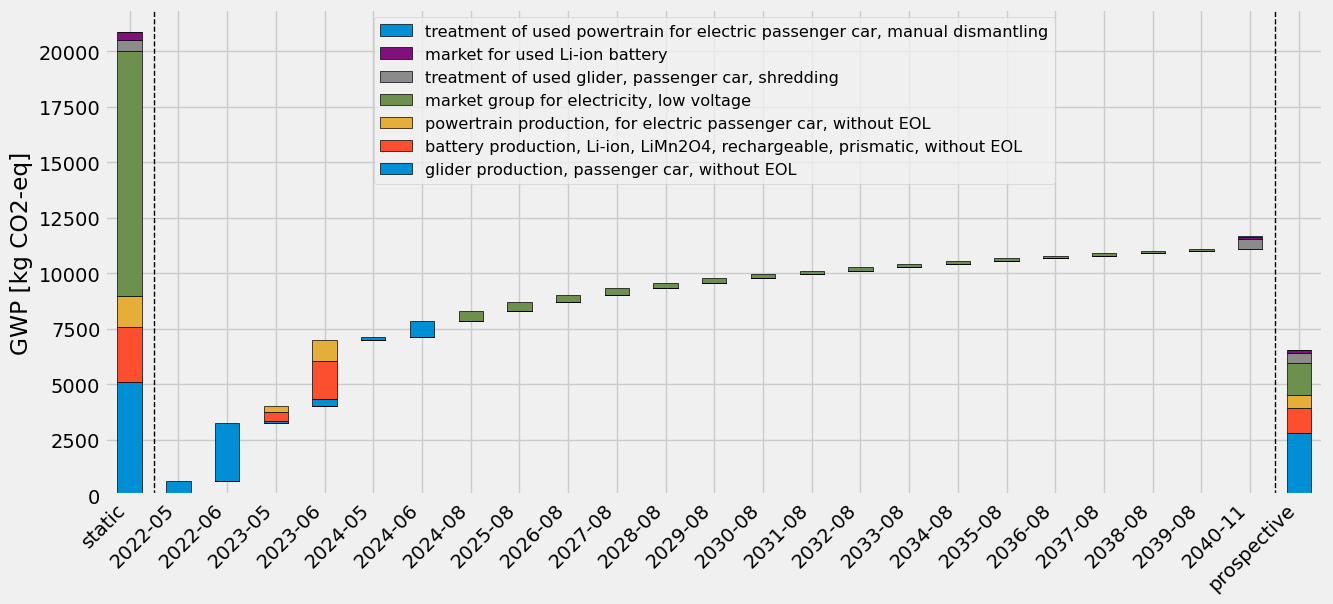

In [213]:
from bw_timex.utils import plot_characterized_inventory_as_waterfall

order_stacked_activities = (
    [ 
        glider_production_without_eol["name"],
        battery_production_without_eol["name"],
        powertrain_production_without_eol["name"],
        electricity_production["name"],
        glider_eol["name"],
        battery_eol["name"],
        powertrain_eol["name"],
    ]
)

plot_characterized_inventory_as_waterfall(
    tlca,
    static_scores=static_scores,
    prospective_scores=prospective_scores,
    order_stacked_activities=order_stacked_activities,
)

One can see that the time-explicit results (in the middle) are somewhere in between the static and the prospective results. This makes sense as at each timestep, the underlying processes are sourced from progressively "cleaner" background databases, reaching a lower impact than if they are only sourced from the current database, but not so low as the prospective results, which are fully sourced from the most decarbonized database. Notably, the electricity consumption in the use-phase, modelled uniformly over the lifetime of the EV, contributes less and less to the score in the later years, since the electricity becomes cleaner in the future databases.